# D7041E Lab 2 - Self Organizing Maps (SOM)
    Alexander Mennborg
    Niklas Lundberg

In [2]:
import os
import math
import time
import numpy as np
import numpy.matlib
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from keras.datasets import mnist


# If the dataset image file is not preset, download it
if not os.path.isfile('zoo.txt'):
    !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1q8ABDWt5L2c-1a6CGHOomz9I4siYD1HB' -O 'zoo.txt'


Using TensorFlow backend.


## 1. Unsupervised learning of hand-written digits with SOM (Self Organizing Maps)

In [0]:
def plot_som(title, nrows, ncols, disp_res, som):
    print(title)
    
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,15))
    
    for k in range(nrows):
        for l in range (ncols):
            A = som[k, l, :].reshape((disp_res[0], disp_res[1]))
            ax[k,l].imshow(A,cmap="plasma")
            ax[k,l].set_yticks([])
            ax[k,l].set_xticks([])   
    plt.show()


def get_euclidean_distance(single_point,array):
    nrows, ncols, nfeatures = array.shape[0], array.shape[1], array.shape[2]
    points = array.reshape((nrows*ncols, nfeatures))
                         
    dist = (points - single_point)**2
    dist = np.sum(dist, axis=1)
    dist = np.sqrt(dist)

    dist = dist.reshape((nrows,ncols))
    return dist

def SOM(disp_res, training_data, **kwargs):
    nfeatures = training_data.shape[1]
    ntraining_vectors = training_data.shape[0]
    ndim = kwargs.get("ndim", 10)
    nepochs = kwargs.get("nepochs", 10)
    eta0 = kwargs.get("eta0", 0.1)
    etadecay = kwargs.get("etadecay", 0.05)
    sgm0 = kwargs.get("sgm0", 20)
    sgmdecay = kwargs.get("sgmdecay", 0.05)
    show_mode = kwargs.get("show_mode", False)
    
    nrows = ndim
    ncols = ndim
    
    mu, sigma = 0, 0.1
    numpy.random.seed(int(time.time()))
    som = np.random.normal(mu, sigma, (nrows, ncols, nfeatures))

    if show_mode:
        plot_som("\nSOM features before training: \n", nrows, ncols, disp_res, som)

    #Generate coordinate system
    x, y = np.meshgrid(range(ncols),range(nrows))
    
    
    for t in range(1, nepochs+1):
        if t == int((nepochs+1)/2) and show_mode:
            plot_som("\nSOM features mid training: \n", nrows, ncols, disp_res, som)


        #Compute the learning rate for the current epoch
        eta = eta0 * math.exp(-t*etadecay)
        
        #Compute the variance of the Gaussian (Neighbourhood) function for the ucrrent epoch
        sgm = sgm0 * math.exp(-t*sgmdecay)
        
        #Consider the width of the Gaussian function as 3 sigma
        width = math.ceil(sgm*3)
        
        for ntraining in range(ntraining_vectors):
            training_vector = training_data[ntraining, :]
            
            # Compute the Euclidean distance between the training vector and
            # each neuron in the SOM map
            dist = get_euclidean_distance(training_vector, som)
       
            # Find 2D coordinates of the Best Matching Unit (bmu)
            bmurow, bmucol = np.unravel_index(np.argmin(dist, axis=None), dist.shape)
            
            
            #Generate a Gaussian function centered on the location of the bmu
            g = np.exp(-((np.power(x - bmucol,2)) + (np.power(y - bmurow,2))) / (2*sgm*sgm))

            #Determine the boundary of the local neighbourhood
            fromrow = max(0, bmurow - width)
            torow   = min(bmurow + width, nrows)
            fromcol = max(0, bmucol - width)
            tocol   = min(bmucol + width, ncols)

            
            #Get the neighbouring neurons and determine the size of the neighbourhood
            neighbour_neurons = som[fromrow:torow, fromcol:tocol, :];
            sz = neighbour_neurons.shape;
            
            #Transform the training vector and the Gaussian function into 
            # multi-dimensional to facilitate the computation of the neuron weights update
            T = np.matlib.repmat(training_vector, sz[0]*sz[1], 1).reshape((sz[0], sz[1], nfeatures));                   
            G = np.dstack([g[fromrow:torow, fromcol:tocol]]*nfeatures);

            # Update the weights of the neurons that are in the neighbourhood of the bmu
            neighbour_neurons = neighbour_neurons + eta * G * (T - neighbour_neurons);

            
            #Put the new weights of the BMU neighbouring neurons back to the
            #entire SOM map
            som[fromrow:torow,fromcol:tocol,:] = neighbour_neurons;

    if show_mode:
        plot_som("\nSOM features after training: \n", nrows, ncols, disp_res, som)

    return som

# Verification of correctness on the training set:
def SOM_Test(training_data, som_, labels, grid_, confusion_matrix, ndim=60):
    nfeatures = training_data.shape[1]
    ntraining_vectors = training_data.shape[0]
    nrows = ndim
    ncols = ndim
    nlabels = np.max(labels)
    som_cl = np.zeros((ndim, ndim, nlabels + 1))
    
    for ntraining in range(ntraining_vectors):
        training_vector = training_data[ntraining, :]
        class_of_sample = labels[ntraining]    
        # Compute the Euclidean distance between the training vector and
        # each neuron in the SOM map
        dist = get_euclidean_distance(training_vector, som_);
        
        # Find 2D coordinates of the Best Matching Unit (bmu)
        bmurow, bmucol = np.unravel_index(np.argmin(dist, axis=None), dist.shape)
        som_cl[bmurow, bmucol, class_of_sample] = som_cl[bmurow, bmucol, class_of_sample] + 1
    
    for i in range(nrows):
        for j in range(ncols):
            grid_[i, j] = np.argmax(som_cl[i, j, :])

    for ntraining in range(ntraining_vectors):
        training_vector = training_data[ntraining,:]
        class_of_sample = labels[ntraining]    
        # Compute the Euclidean distance between the training vector and
        # each neuron in the SOM map
        dist = get_euclidean_distance(training_vector, som_)
       
        # Find 2D coordinates of the Best Matching Unit (bmu)
        bmurow, bmucol = np.unravel_index(np.argmin(dist, axis=None), dist.shape)
        
        predicted = np.argmax(som_cl[bmurow, bmucol,:])
        confusion_matrix[class_of_sample-1, predicted-1] = confusion_matrix[class_of_sample - 1, predicted - 1] + 1
        
    return grid_, confusion_matrix


### 1.1 Load the MNIST dataset

Train tensor shape: (60000, 28, 28)


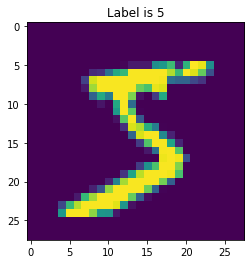

In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print("Train tensor shape: " + str(x_train.shape))
img = x_train[0,:,:]
label = y_train[0]
plt.title('Label is {Label}'.format(Label=label))
plt.imshow(img)
plt.show()
plt.close()

### 1.2 Use the flatten (1D) array of pixels of each images as a feature vector

In [5]:
def training_batch(num_samples): # Batch is a tuple containing (images[], labels[])
    x_set = x_train[:num_samples, :, :]
    return x_set.reshape(num_samples, x_set.shape[1]*x_set.shape[2]), y_train[:num_samples]

def testing_batch(num_samples): # Test batch is simply an array of images
    x_set = x_test[:num_samples, :, :]
    return x_set.reshape(num_samples, x_set.shape[1]*x_set.shape[2]), y_test[:num_samples]

num_samples = 500
x_train, y_train = training_batch(num_samples)
x_test, y_test = testing_batch(num_samples)
print(x_train.shape)

(500, 784)


### 1.3 Initializing the weights in the SOM network randomly
Train SOM with grid 20x20, 40x40 and 80x80.

### 1.4 Display the initial, intermediate and final learned weights of SOM neurons as a grid of 28x28

In [6]:
parameters = {"ndim": 20, "nepochs": 100, "eta0": 0.01, "etadecay": 0.05, "sgm0": 20, "sgmdecay": 0.05, "show_mode": True}
som_20 = SOM([28,28], x_train, **parameters)
#parameters["ndim"] = 40
#som_40 = SOM([28,28], x_train, **parameters)
#parameters["ndim"] = 80
#som_80 = SOM([28,28], x_train, **parameters)

Output hidden; open in https://colab.research.google.com to view.

### 1.5 Test SOM
Now by passing the TRAINING examples through the trained SOM and recording the statistics of matching in each node assign labels to the neurons.
- Display the confusion matrix of classification of the TRAINING SET
- Display the confusion matrix of classification of the TEST SET

In [0]:
def run_som_test(som, dataset, labels, ndim):
    grid_color = np.zeros((ndim, ndim))
    nlabels = np.max(labels) + 1
    confusion_matrix = np.zeros((nlabels, nlabels))
    return SOM_Test(dataset, som, labels, grid_color, confusion_matrix, ndim)

def plot_confusion_matrix(confusion_matrix, nlabels):
    df_cm = pd.DataFrame(confusion_matrix, 
                index = [i for i in range(nlabels)],
                columns = [i for i in range(nlabels)])
    plt.figure(figsize=(12, 10))
    sns.heatmap(df_cm, annot=True)
    plt.show()



#### 1.5.1 Test SOM on the training set

Confusion Matrix:


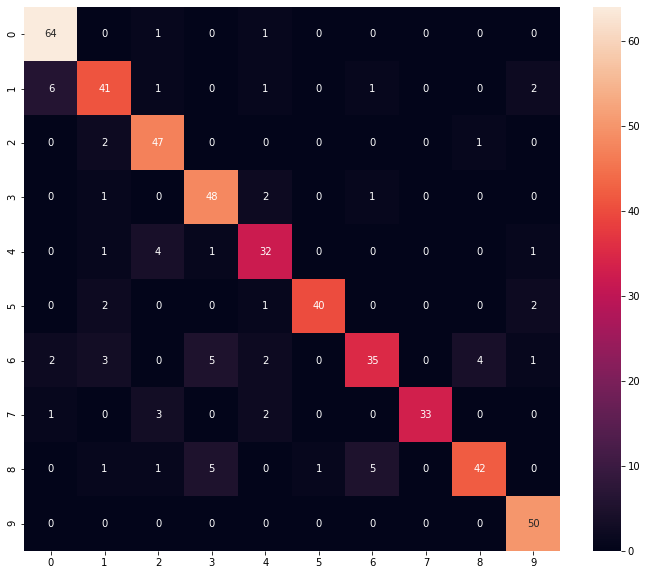

Grid Color:


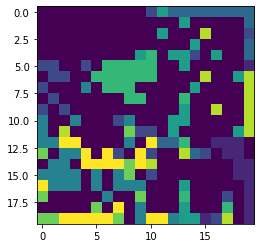

In [8]:
#acc = 0.98
grid_color, cmatrix = run_som_test(som_20, x_train, y_train, parameters['ndim'])

print("Confusion Matrix:")
plot_confusion_matrix(cmatrix, np.max(y_train) + 1)

print("Grid Color:")
plt.close()
plt.imshow(grid_color)
plt.show()

#### 1.5.2 Test SOM on the test set

Confusion Matrix:


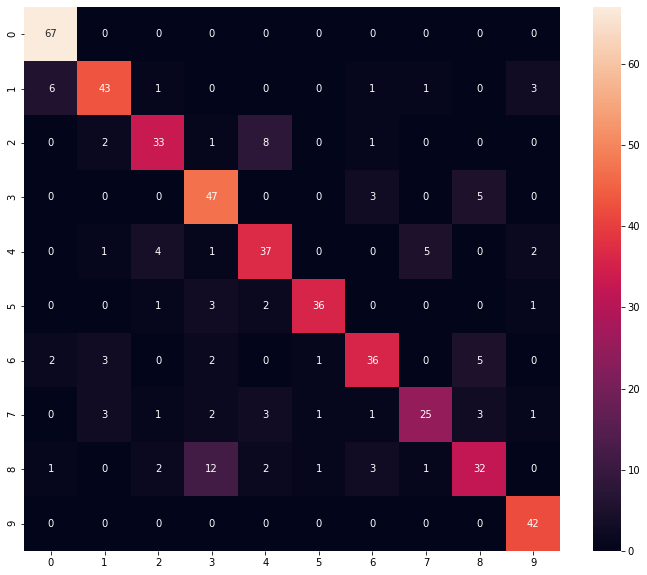

Grid Color:


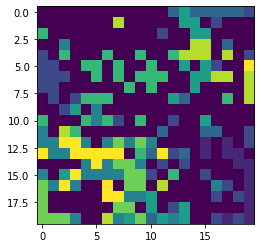

In [9]:
test_grid_color, test_cmatrix = run_som_test(som_20, x_test, y_test, parameters['ndim'])

print("Confusion Matrix:")
plot_confusion_matrix(test_cmatrix, np.max(y_train) + 1)

print("Grid Color:")
plt.close()
plt.imshow(test_grid_color)
plt.show()

### 1.6 Increase and decrease learning rate

When we increased the learning rate we got a a little better result.

When we decreased the learning rate the priductions got very bad. It almost always predicted 8.

In [0]:
def run_som_with_lr(lr=0.01, lr_decay=0.05, show_mode=False):
    parameters = {"ndim": 20, "nepochs": 100, "eta0": lr, "etadecay": lr_decay,
                  "sgm0": 20, "sgmdecay": 0.05, "show_mode": show_mode}
    som_20 = SOM([28,28], x_train, **parameters)
    test_grid_color, test_cmatrix = run_som_test(som_20, x_test, y_test, parameters['ndim'])

    print("Confusion Matrix:")
    plot_confusion_matrix(test_cmatrix, np.max(y_train) + 1)

    print("Grid Color:")
    plt.close()
    plt.imshow(test_grid_color)
    plt.show()

#### 1.6.1 Increase learning rate eta0 = 0.1

Confusion Matrix:


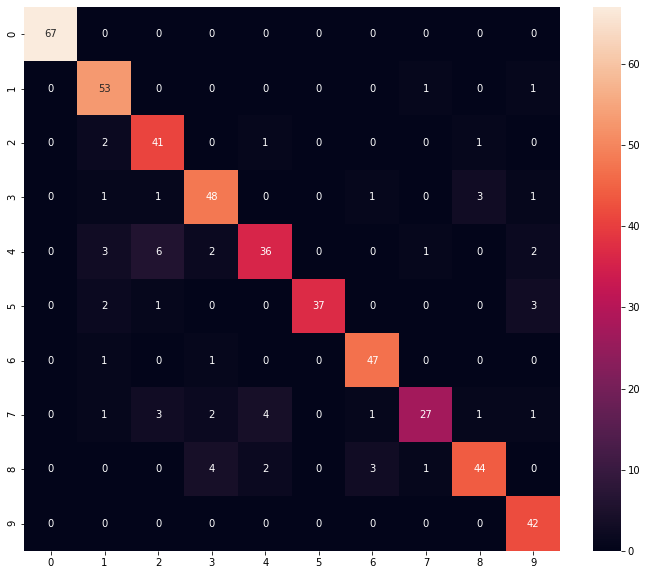

Grid Color:


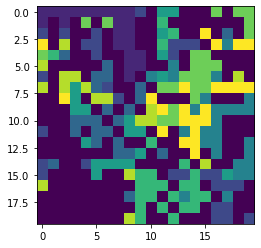

In [11]:
run_som_with_lr(lr=0.1)

#### 1.6.2 Decrease learning rate eta0 = 0.0001

Confusion Matrix:


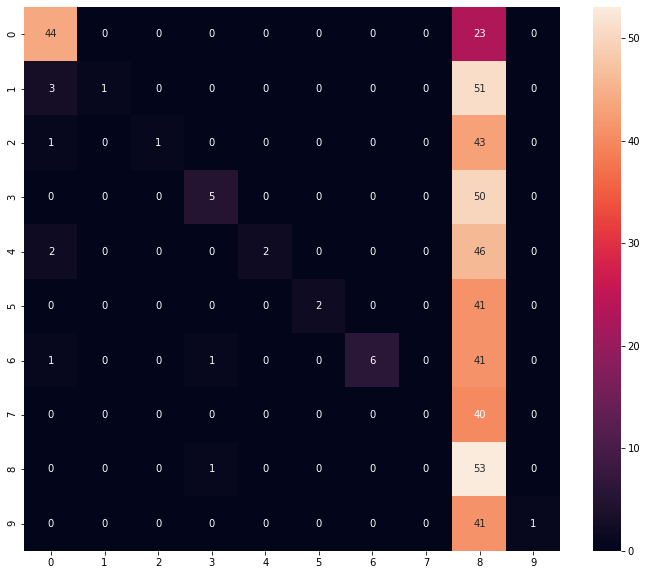

Grid Color:


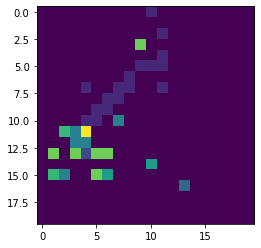

In [12]:
run_som_with_lr(lr=0.0001)

Rusult after training SOM:


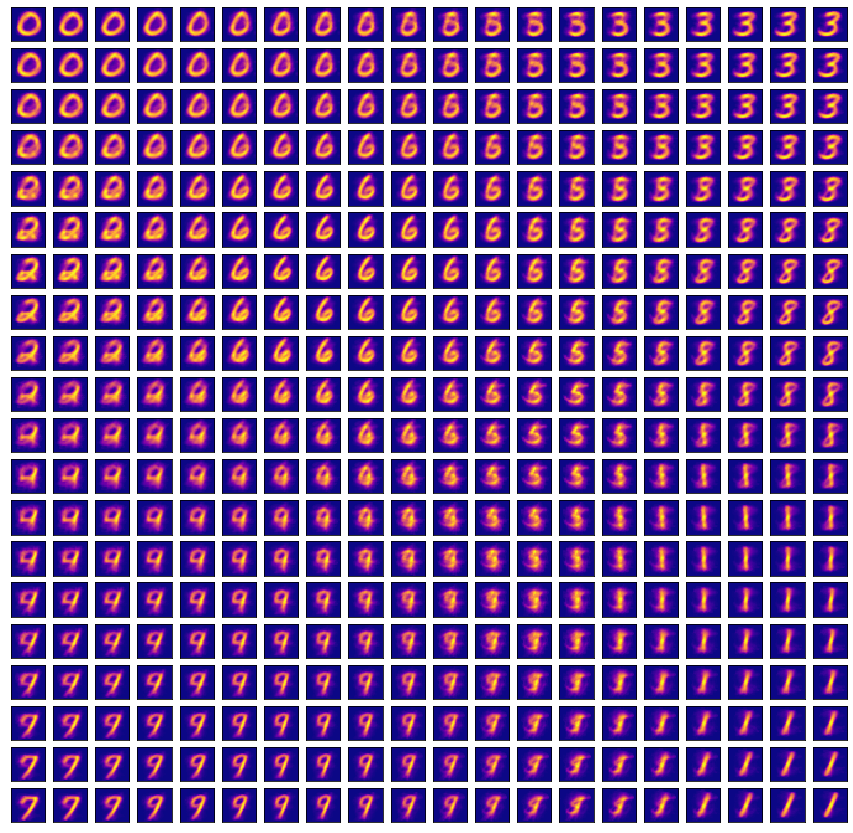

In [13]:
plot_som("Rusult after training SOM:", 20, 20, [28,28], som_20)

### 1.7 For a fixed number of iterations and the best learning rate increase and decrease the exponential decay of the neighbourhood parameter

#### 1.7.1 Increase learning rate decay etadecay = 0.1

Confusion Matrix:


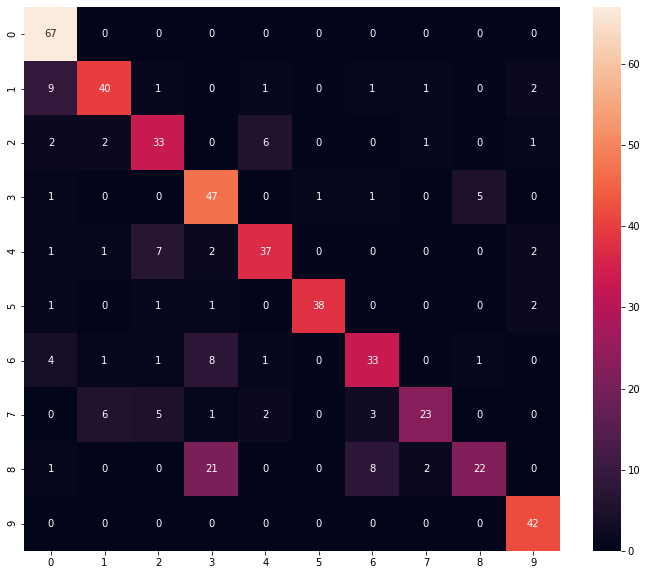

Grid Color:


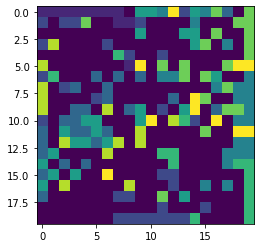

In [14]:
run_som_with_lr(lr_decay=0.1)

#### 1.7.2 Decrease learning rate decay etadecay = 0.001

Confusion Matrix:


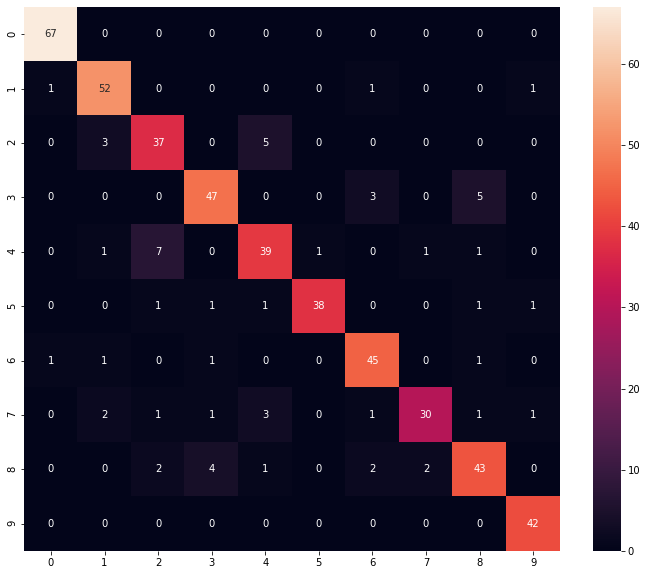

Grid Color:


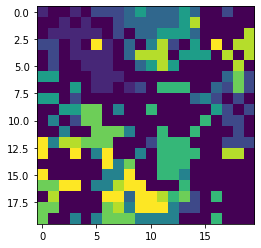

In [15]:
run_som_with_lr(lr_decay=0.0001)

### 1.8 What is the effect?

When we increased the learning rate decay the result got a little worse. 

When we decreased the learning rate decay the result got a little better.


### 1.9 What is a biological neuron? How does it relate to the concept of neurons in SOM?

The neurons in SOM are mathematical models of biological neurons.